# Final project
## Deep Reinforcement Learning
Creating simple minigrid environment, and letting the agent learn to reach the goal using DQN where the first NN is a simple MLP and the second NN is a CNN with dropout, batch normalization and residual connections. ??

In [ ]:
!pip install minigrid
## import the necessary packages for the minigrid environment
from __future__ import annotations
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.actions import Actions


## import the necessary packages for NN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque

## import the necessary packages for the training
import os
import matplotlib.pyplot as plt
import copy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 20.6 MB/s eta 0:00:00
pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/JHU_DL'
os.getcwd()
os.listdir()

Mounted at /content/drive
/content/drive/MyDrive/JHU_DL


['HW7',
 'training_plot.png',
 'model2.pth',
 'minigrid copy.ipynb',
 'Model.pth',
 'minigrid.ipynb']

## Defining the environment

In [ ]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size,
        seed,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.size = size
        self.seed=seed

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            # see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "Grand mission"

    def position_(self, pos):
        if not pos:
            random.seed(self.seed)   # seed for random number generator
            random_number = [random.randint(1, self.size - 2), random.randint(1, self.size - 2)]
            while random_number == [self.agent_start_pos[0], self.agent_start_pos[1]] or random_number==[self.size-2, self.size-2]:
                random_number = [random.randint(1, self.size - 2), random.randint(1, self.size - 2)]
        else:
            random.seed(self.seed*2)   # seed for random number generator
            random_number = [random.randint(1, self.size - 2), random.randint(1, self.size - 2)]
            while random_number == pos or random_number == [self.agent_start_pos[0], self.agent_start_pos[1]] or random_number==[self.size-2, self.size-2]:
                random_number = [random.randint(1, self.size - 2), random.randint(1, self.size - 2)]

        return random_number

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        self.step_count += 1

        reward = 0
        terminated = False
        truncated = False

        # Get the position in front of the agent
        fwd_pos = self.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = self.grid.get(*fwd_pos)

        # Rotate left
        if action == self.actions.left:
            self.agent_dir -= 1
            if self.agent_dir < 0:
                self.agent_dir += 4
            if not isinstance(fwd_cell, Door) and not isinstance(fwd_cell, Key) and fwd_cell is not None and fwd_cell.type != "goal":
              reward=self._reward(k=-0.05)
            else:
              reward=self._reward(k=-0.01)

        # Rotate right
        elif action == self.actions.right:
            self.agent_dir = (self.agent_dir + 1) % 4
            if not isinstance(fwd_cell, Door) and not isinstance(fwd_cell, Key) and fwd_cell is not None and fwd_cell.type != "goal":
              reward=self._reward(k=-0.05)
            else:
              reward=self._reward(k=-0.01)

        # Move forward
        elif action == self.actions.forward:
            if fwd_cell is None or fwd_cell.can_overlap():
                self.agent_pos = tuple(fwd_pos)
            if fwd_cell is not None and fwd_cell.type == "goal":
                terminated = True
                reward = self._reward(k=2)
            if fwd_cell is not None and fwd_cell.type == "lava":
                terminated = True
                reward = self._reward(k=-1)
            if not terminated:
              reward=self._reward(k=-0.01)

        # Pick up an object
        elif action == self.actions.pickup:
            if fwd_cell and fwd_cell.can_pickup() and isinstance(fwd_cell, Key):
                if self.carrying is None:
                    self.carrying = fwd_cell
                    self.carrying.cur_pos = np.array([-1, -1])
                    self.grid.set(fwd_pos[0], fwd_pos[1], None)
                    # self.holdingkey=True
                    reward = self._reward(k=0.1)
            if not isinstance(fwd_cell, Key):
              reward=self._reward(k=-0.05)

        # Drop an object
        elif action == self.actions.drop:
            if not fwd_cell and self.carrying:
                self.grid.set(fwd_pos[0], fwd_pos[1], self.carrying)
                self.carrying.cur_pos = fwd_pos
                self.carrying = None
                reward = self._reward(k=-0.1)
            elif self.carrying is None:
                reward = self._reward(k=-0.05)

        # Toggle/activate an object
        elif action == self.actions.toggle:
            if fwd_cell and isinstance(fwd_cell, Door) and self.carrying is not None:
                fwd_cell.toggle(self, fwd_pos)
                self.grid.set(fwd_pos[0], fwd_pos[1], None)
                reward = self._reward(k=0.2)
            if not isinstance(fwd_cell, Door):
              reward=self._reward(k=-0.05)

        # Done action (not used by default)
        elif action == self.actions.done:
            pass

        else:
            raise ValueError(f"Unknown action: {action}")

        if self.step_count >= self.max_steps:
            truncated = True

        if self.render_mode == "human":
            self.render()

        obs = self.gen_obs()

        return obs, reward, terminated, truncated, {}


    def _reward(self,k) -> float:
        """
        Compute the reward to be given upon success, if any
        k: 0.2 for key, 0.2 for door, 1 for goal
        """

        return (1 - 0.9 * (self.step_count / self.max_steps))*k

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(self.size, self.size)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, self.size, self.size)

        # # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())

        # Place the door and key
        _door=self.position_(pos=False)
        _key=self.position_(pos=_door)

        # self.grid.set(_door[0],_door[1], Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(_door[0],_door[1], Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(_key[0], _key[1], Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.size - 2, self.size - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "Grand mission"

## Defining the network

In this model the agent is blind to the environment. The agent only knows its position

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN,self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 256)
        # self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(output_size, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
      x = self.relu(self.fc1(x))
      # x = self.relu(self.fc2(x))
      # x = self.relu(self.fc3(x))
      x = self.fc4(x)
      return x

## Defining the agent and the action selection

Action space: Action space is a discrete space of size 7, corresponding to the following actions:

0: left: Turn left
1: right: Turn right
2: forward: Move forward
3: pickup: Pick up an object
4: drop: Drop an object
5: toggle: Toggle/activate an object
6: done: Stop the agent

In [ ]:
class DQNAgent:
    def __init__(self, capacity,periodic_update,batch_size=200,input=8,output=6,lr=0.001,device="cpu"):

        self.memory = deque(maxlen=capacity)
        if device!="cpu":
            self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = 0.9 # discount rate

        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.99 # exponential decay rate for exploration prob

        self.q_net = DQN(input, output)
        self.target_net=DQN(input, output)
        self.target_net.load_state_dict(self.q_net.state_dict())
        ## send the model to the GPU
        if self.device:
            self.q_net.to(self.device)
            self.target_net.to(self.device)

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.capacity = capacity
        self.periodic_update = periodic_update
        self.batch_size = batch_size

    def get_state(self, env):
       # Get the agent's position and direction
       agent_pos = env.agent_pos
       agent_dir = env.agent_dir
       one_hot_dir=[0] * 4
       one_hot_dir[agent_dir]=1

       # Get key and door positions, and door state
       key_pos = None
       key_car = True
       door_pos = None
       door_open = True

       # Search the grid for the key and the door
       for x in range(env.width):
           for y in range(env.height):
               cell = env.grid.get(x, y)
               if isinstance(cell, Key):
                   key_car= False
               elif isinstance(cell, Door):
                   door_open = False

       # State representation
       state = [
           (agent_pos[0]-1)/(env.size-2-1)*2-1, (agent_pos[1]-1)/(env.size-2-1)*2-1,
           one_hot_dir[0],one_hot_dir[1],one_hot_dir[2],one_hot_dir[3],
           int(key_car),
           int(door_open)]

       self.for_get_action=env.action_space.n-1 #removing the last action
       return np.array(state)

    def get_action(self,state,dim=0):
        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            action= np.random.randint(self.for_get_action)
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            with torch.no_grad():
                action = torch.argmax(self.q_net(state), dim=dim).item()

        return action

    def get_next_q(self, next_state,dim=0):
        with torch.no_grad():
            next_q, _ = torch.max(self.target_net(next_state), dim=dim)
            # print("next_q",_)
        return next_q


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def from_memory(self):
        if len(self.memory) > self.batch_size:
            mini_sample = random.sample(self.memory, self.batch_size)
        else:
            mini_sample = self.memory


        return mini_sample



## Training the agent

In [ ]:
env=SimpleEnv(render_mode="rgb_array",size=5,seed=3)
env.reset(seed=32)
torch.manual_seed(3)

num_episodes = 100
env.max_steps = 500
learning_rate = 0.0001
periodic_update=100
capacity=10000
batch_size=200
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DQNAgent(input=8,output=6,batch_size=batch_size,capacity=capacity,periodic_update=periodic_update,lr=learning_rate,device='gpu')

plot_scores = []
plot_loss_present = []
plot_loss_past = []
loss_series_past_total=[]
total_score = 0

step_count = 0

for episode in range(num_episodes):
    env.reset(seed=32)
    score = 0
    loss_present=0
    loss_series_past=[]
    current_state = agent.get_state(env)
    done = False
    step_count_tmp=0
    while step_count_tmp<env.max_steps:
        current_state_ = torch.tensor(current_state,dtype=torch.float).cuda()
        action = agent.get_action(current_state)

        pred_q = agent.q_net(current_state_)

        pred_return , _ =torch.max(pred_q, dim=0)

        _, reward, done, extra_flag, info = env.step(action)

        target_q = agent.get_next_q(current_state_)
        target_value=reward+agent.gamma*target_q*(1-done)
        agent.optimizer.zero_grad()
        loss=agent.loss_fn(pred_return, target_value)
        loss.backward()
        agent.optimizer.step()
        loss_present+=loss.item()
        score += reward
        if not done:
            state_new = agent.get_state(env)
        else:
            happened_at=env.step_count
            env.reset(seed=32)
            state_new = agent.get_state(env)*0

        agent.remember(current_state, action, reward, state_new, done)

        if np.array_equal(state_new, np.zeros_like(state_new)):
          state_new=agent.get_state(env)

        current_state = state_new

        loss_past=0
        for past_episod in range(1):
          learn_from_past=agent.from_memory()
          mini_batch = list(zip(*learn_from_past))
          state = torch.tensor(mini_batch[0], dtype=torch.float32).to(device)
          action = torch.tensor(mini_batch[1], dtype=torch.long).to(device)  # Assuming action is discrete, adjust dtype accordingly
          reward = torch.tensor(mini_batch[2], dtype=torch.float32).to(device)
          next_state = torch.tensor(mini_batch[3], dtype=torch.float32).to(device)
          done = torch.tensor(mini_batch[4], dtype=torch.float32).to(device)
          target_q = agent.get_next_q(next_state,dim=1)
          target_value=reward+agent.gamma*target_q*(1-done)
          pred_return=agent.q_net(torch.tensor(state, dtype=torch.float).to(device)).gather(1, action.unsqueeze(1))
          agent.optimizer.zero_grad()
          loss=agent.loss_fn(pred_return, target_value.detach())
          loss.backward()
          loss_past+=loss.item()
          agent.optimizer.step()

          loss_series_past.append(loss_past)
          if (step_count+1) % int(env.max_steps)==0:
            agent.epsilon = max(agent.epsilon_min, agent.epsilon_decay*agent.epsilon)

          if (step_count+1) % (agent.periodic_update)==0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

          step_count+=1

        step_count_tmp+=1
    print("Episode",episode,", Loss from interaction:", loss_present,", Mean loss of past",np.mean(loss_series_past))
    print('Episode', episode, 'Score', score)

    plot_scores.append(score)
    total_score += score
    plot_loss_present.append(loss_present)
    loss_series_past_total.append(np.mean(loss_series_past))

torch.save(agent.q_net.state_dict(), 'Model.pth')



<ipython-input-72-843e93512b64>:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_return=agent.q_net(torch.tensor(state, dtype=torch.float).to(device)).gather(1, action.unsqueeze(1))


Episode 0 , Loss from interaction: 2.4128847612664686 , Mean loss of past 0.1364888323098421
Episode 0 Score -11.890258
Episode 1 , Loss from interaction: 5.716329139169829 , Mean loss of past 0.05873893640190363
Episode 1 Score -9.127812000000006
Episode 2 , Loss from interaction: 6.322665915795369 , Mean loss of past 0.034798693604767325
Episode 2 Score -9.617461999999994
Episode 3 , Loss from interaction: 3.175581585994223 , Mean loss of past 0.021646005179733037
Episode 3 Score -10.128518
Episode 4 , Loss from interaction: 13.22807722590369 , Mean loss of past 0.0174691930860281
Episode 4 Score -4.975141999999996
Episode 5 , Loss from interaction: 1.4084149795598933 , Mean loss of past 0.01652661591582
Episode 5 Score -11.43821400000001
Episode 6 , Loss from interaction: 5.570529524527956 , Mean loss of past 0.015124881062656642
Episode 6 Score -8.026186000000001
Episode 7 , Loss from interaction: 0.7824475301592742 , Mean loss of past 0.013201296580955386
Episode 7 Score -9.968499

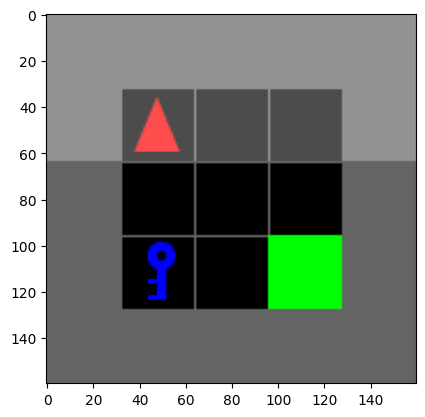

In [ ]:
plt.imshow(env.render())

(array([1039.,    0., 1447.,    0., 3578.,    0., 1550.,    0., 1488.,
         898.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

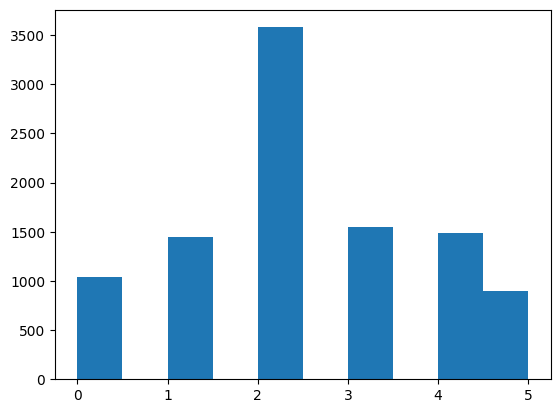

In [ ]:
a=agent.memory
b=list(a)
c=[inner_list[1] for inner_list in b]
plt.hist(c)
# # # mini_batch = list(zip(*learn_from_past))
# # mini_batch[2]
# [value for value in c if value > 2]

Text(0, 0.5, 'Loss of trianing from the past experience')

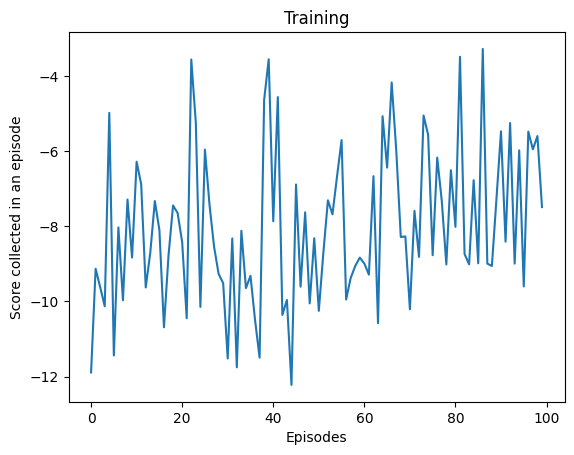

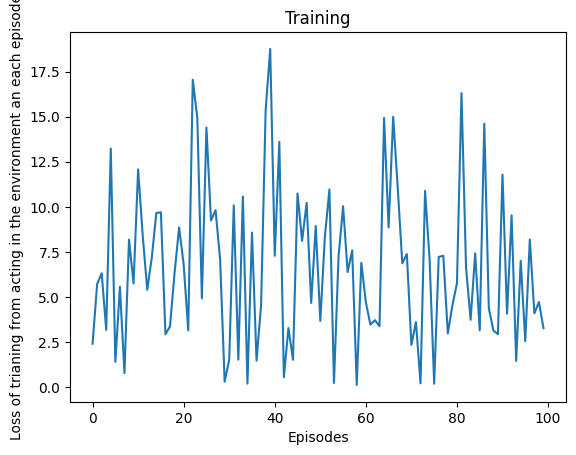

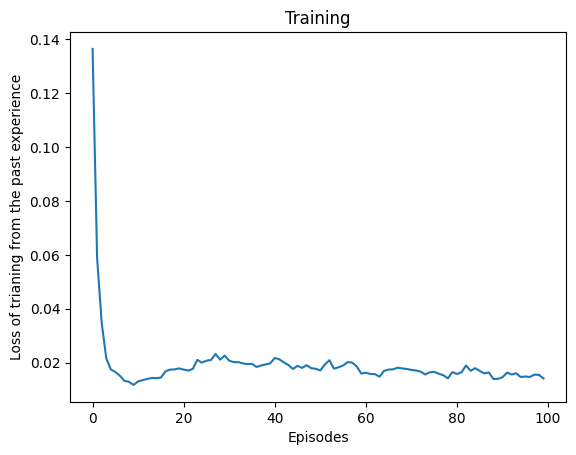

In [ ]:
plt.figure(1)
plt.plot(plot_scores)
plt.title('Training')
plt.xlabel('Episodes')
plt.ylabel('Score collected in an episode')

plt.figure(2)
plt.plot(plot_loss_present)
plt.title('Training')
plt.xlabel('Episodes')
plt.ylabel('Loss of trianing from acting in the environment an each episode')

plt.figure(3)
plt.plot(loss_series_past_total)
plt.title('Training')
plt.xlabel('Episodes')
plt.ylabel('Loss of trianing from the past experience')


